## Purpose of embedding
Embeddings are numbers that represent meaning.
They turn any text (a person’s profile, skills, job description) into a long list of numbers — like a fingerprint of what that text means.

Two embeddings that are close → mean the people are similar.
Two embeddings that are far → mean the people are different.

For example, 
Skills: Skills: Selenium, Kubernetes, OpenShift
[0.12, -0.03, 0.88, ..., 0.05]
+ If 2 ppl have similar role or skils, their vectors will be close 
+ If they are different, their vectors will be far

We will use that to:
+ measure similarity
+ cluster people
+ build better graph edges

In [7]:
%pip install openai pandas scikit-learn matplotlib seaborn dotenv

Note: you may need to restart the kernel to use updated packages.


In [8]:
from pathlib import Path
import sys
import json

# add the repo root (…/service) so `models` is importable
ROOT = Path("..").resolve()        # points to service/
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

BASE_DIR = Path("..")          # adjust if notebook is somewhere else
PEOPLE_PATH = BASE_DIR / "data" / "people.json"

with PEOPLE_PATH.open("r", encoding="utf-8") as f:
    people = json.load(f)

len(people), people[0].keys()

(148,
 dict_keys(['_id', 'name', 'company', 'role', 'schools', 'skills', 'keywords', 'seniority', 'connections', 'embedding']))

#### List the field

In [9]:
def profile_to_text(profile):
    """Turn one profile dict into a single text string."""
    parts = [
        p.get("name", ""),
        f"Role: {p.get('role', '')}",
        f"Company: {p.get('company', '')}",
        "Schools: " + ", ".join(p.get("schools", [])),
        "Skills: " + ", ".join(p.get("skills", [])),
        "Keywords: " + ", ".join(p.get("keywords", [])),
        f"Seniority: {p.get('seniority', '')}",
    ]
    # Remove empty pieces
    parts = [x for x in parts if x and x.strip()]
    return "\n".join(parts)
    

for p in people[:3]:
    print("---- PROFILE ----")
    print("ID:", p.get("id"))
    print(profile_to_text(p))
    print("-" * 40)

---- PROFILE ----
ID: None
Travis Liu
Role: Software Engineer in Test
Company: RBC
Schools: Seneca Polytechnic
Skills: API Testing, CI/CD, Docker, Dynatrace, Elastic Stack (ELK), JavaScript/TypeScript, Kubernetes, MongoDB, Next.js, OpenShift, Python, React.js, REST APIs, Selenium, Software Testing, Test Automation, Test Engineering, Web Testing
Keywords: automation, cloud-native, DevOps, observability, quality assurance
Seniority: Other
----------------------------------------
---- PROFILE ----
ID: None
Kristina Zaporozhets
Role: Global Analytics and Financial Engineer Intern
Company: Scotiabank
Schools: Seneca Polytechnic
Skills: C, C++, Applied Research, Communication, Git, Machine Learning, Problem Solving, Software Development, Teamwork
Keywords: analytics, financial engineering, software development, machine learning, applied research
Seniority: Student/Intern
----------------------------------------
---- PROFILE ----
ID: None
Ngoc Vien Do
Role: Software Developer
Company: 
School

#### Set up the embedding

In [10]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv("../.env") 

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["api_key"],)

EMBED_MODEL = "text-embedding-3-large"

In [11]:
def embed_text(text: str) -> list[float]:
    """Get embedding vector for one text string."""
    response = client.embeddings.create(
        input=text,
        model=EMBED_MODEL
    )
    embedding = response.data[0].embedding
    return embedding

#### Compute embeddings for all people

In [12]:
from tqdm import tqdm

for p in tqdm(people):
    text = profile_to_text(p)
    p["embedding"] = embed_text(text)

  0%|          | 0/148 [00:00<?, ?it/s]


AuthenticationError: Error code: 401 - {'error': {'message': 'User not found.', 'code': 401}}

In [ ]:
with open("embeddings.json", "w", encoding="utf-8") as f:
    json.dump(people, f, ensure_ascii=False, indent=2)

#### Use embeddings to measure similarity

In [ ]:
import numpy as np

def cosine_sim(a, b):
    a = np.array(a)
    b = np.array(b)
    return float(a @ b / (np.linalg.norm(a) * np.linalg.norm(b)))

# Build index: _id -> profile
id_to_profile = {p["_id"]: p for p in people}


def most_similar(target_id, top_k=5):
    target = id_to_profile[target_id]
    e0 = target["embedding"]
    scores = []
    for p in people:
        if p["_id"] == target_id:
            continue
        if "embedding" not in p:
            continue
        score = cosine_sim(e0, p["embedding"])
        scores.append((score, p))
    scores.sort(reverse=True, key=lambda x: x[0])
    return scores[:top_k]


## Example

These numbers are cosine similarity scores between Cris Huynh’s embedding and other people’s embeddings.
+ 1.0 = Perfect match (identical meaning)
+ 0.8–0.9 = Very similar background
+ 0.7–0.8 = Similar field / strong overlap
+ 0.6–0.7 = Some overlap
+ <0.5 = Weak similarity

This means Andrew Nguyen’s background (roles + skills + keywords) is very similar to Cris Huynh’s background.

The similarity scores represent how closely each person’s background matches Cris Huynh’s profile using embedding vectors. An embedding turns each profile into a numerical representation that captures its meaning (skills, role, company type, and keywords). A cosine similarity score close to 1 means the two profiles are highly alike. For example, Andrew Nguyen (0.807) is extremely similar to Cris because both work in software development with comparable tech stacks. Scores around 0.7 still reflect meaningful overlap—similar roles, industries, or skill sets. This ranking helps identify which people are the strongest “natural connections” in terms of background, making networking paths more logical and realistic.

In [ ]:
top = most_similar("cris_huynh_2a52b5274", top_k=10)
for score, p in top:
    print(f"{score:.3f} | {p['name']} | {p.get('company')} | {p.get('role')}")

0.807 | Andrew Nguyen | KPMG Canada | Software Engineer
0.795 | Khoi Vu | RBC | Full-stack Developer
0.781 | Krins Vaghasia | RBC | Software Developer
0.724 | Jay Vakil | KPMG Canada | Senior Developer
0.707 | Natalie Vu | RBC | Senior Software Developer
0.702 | Christie Tang | RBC | Developer Intern
0.701 | Vladyslav Huziienko | Autodesk | Software Developer Intern
0.700 | Gurmehak Kaur Uppal | RBC | Software Developer & Quality Engineering
0.687 | Nadimul Hasan | Bell | Software Developer
0.684 | Jessica Lam | RBC | Frontend Developer


### Graph

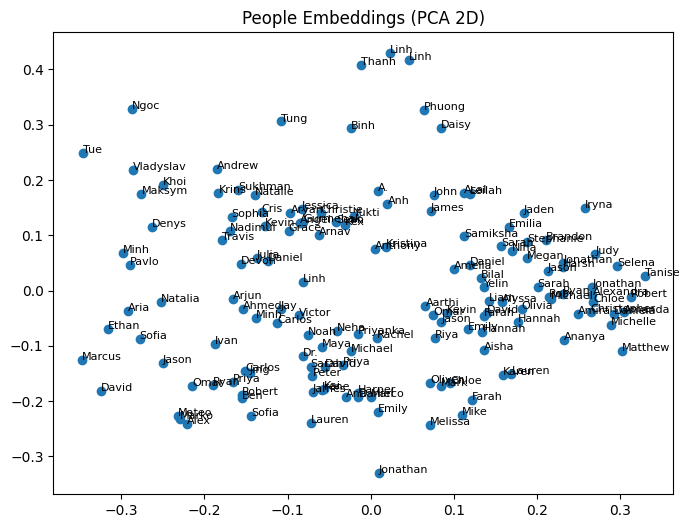

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA  # pip install scikit-learn
import matplotlib.pyplot as plt

# Put embeddings into matrix
emb_matrix = np.array([p["embedding"] for p in people if "embedding" in p])
names = [p["name"] for p in people if "embedding" in p]
companies = [p.get("company", "") for p in people if "embedding" in p]

# 2D PCA
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(emb_matrix)

df_plot = pd.DataFrame({
    "x": coords_2d[:, 0],
    "y": coords_2d[:, 1],
    "name": names,
    "company": companies,
})

plt.figure(figsize=(8, 6))
plt.scatter(df_plot["x"], df_plot["y"])
for _, row in df_plot.iterrows():
    plt.text(row["x"], row["y"], row["name"].split()[0], fontsize=8)
plt.title("People Embeddings (PCA 2D)")
plt.show()

## Graph ex from a person

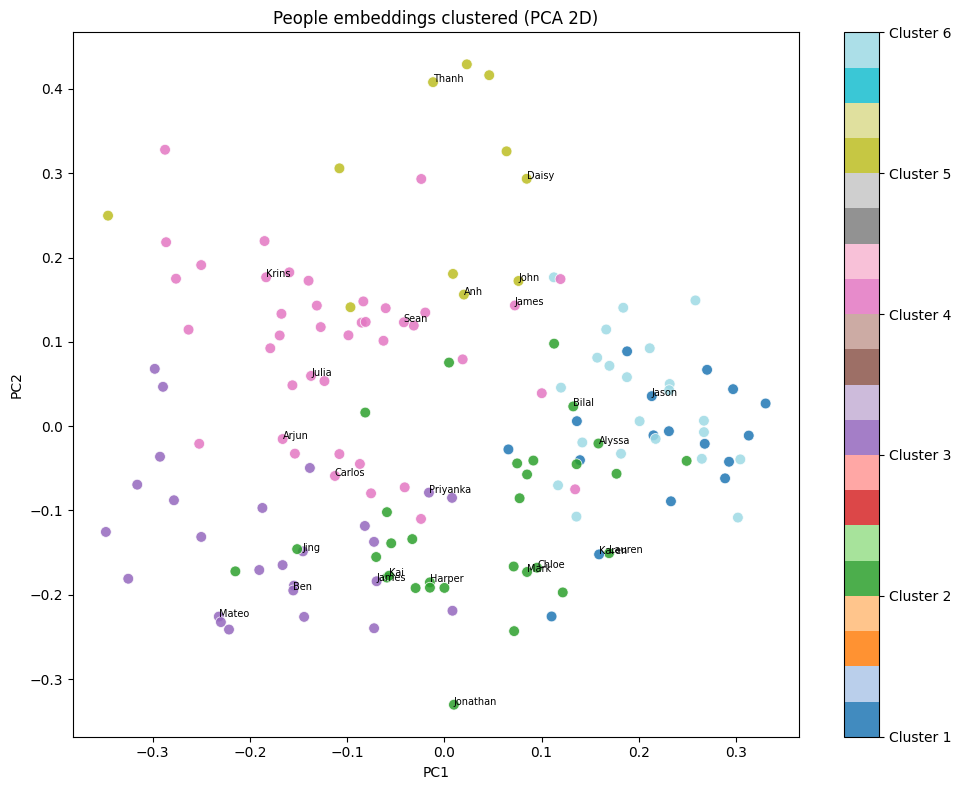

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Gather embeddings
emb_matrix = np.array([p["embedding"] for p in people if "embedding" in p])
names = [p["name"] for p in people if "embedding" in p]
ids = [p["_id"] for p in people if "embedding" in p]

# Reduce to 2D for plotting
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(emb_matrix)

# KMeans clustering
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(emb_matrix)
cluster_map = dict(zip(ids, cluster_labels))

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=cluster_labels,
    cmap="tab20",
    s=60,
    alpha=0.85,
    edgecolor="white",
    linewidth=0.6,
)

# Only label a subset to keep the plot readable
for (x, y, name) in zip(X_2d[:, 0], X_2d[:, 1], names):
    if np.random.rand() < 0.15:
        plt.text(x, y, name.split()[0], fontsize=7)

cbar = plt.colorbar(sc, ticks=range(n_clusters))
cbar.ax.set_yticklabels([f"Cluster {i+1}" for i in range(n_clusters)])

plt.title("People embeddings clustered (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


## Explaination
+ Each dot = one person. We turn every profile (skills, role, company, seniority) into a numeric embedding vector, then use PCA to compress it to 2D so it can be plotted.
+ Distance = similarity. People who are close together in the plot have more similar profiles (skills / roles / industries); people far apart are less similar.
+ Clusters reveal “neighborhoods” in the talent graph. Groups of nearby points correspond to hidden communities (e.g., RBC devs, KPMG tech, big-tech engineers), which helps us find realistic connection paths between any two people.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

We create this embedding plot because the raw network is too big and messy to understand. Embeddings turn each person’s full profile (skills, role, company, seniority, connections) into a single numerical vector that captures their overall “identity.” When we reduce these vectors into 2D using PCA, we can visualize the whole community at once. People who appear close together on the plot are more similar, and people far apart are very different. This gives a bird’s eye view of the hidden structure in the network clusters of similar people, isolated individuals, and how the entire ecosystem is organized.

**PCA (Principal Component Analysis)** is a linear dimensionality reduction algorithm that projects high-dimensional data onto a lower-dimensional space to simplify it while retaining most of the original information

#### Take it example as this image: 

**Daniela Rivera (Scotiabank), Michelle Clarke (RBC), Ananya Das (CIBC), and Matthew O’Reilly (Deloitte)**

These four senior leaders appear close together in the embedding plot because the model captures semantic similarity across skills, roles, keywords, and education. Even though they work at different companies (RBC, CIBC, Deloitte, Scotiabank), they all share high-level leadership skills, strategic responsibilities, and senior roles (VP, Senior Manager, Partner). Their professional themes — such as financial services, people leadership, organizational strategy, and executive communication — make their embeddings cluster naturally in the same region.
